# MNIST Digits classification with Pytorch En(hanced) Lightning
This notebook duplicates the code in the `./mnist/pyt_lightning_mnist.py` script. Notebook written to check if the Pytorch En(hanced)Lightning library works in a notebook setting too.

In [1]:
!pip install overrides torchmetrics pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

import os
import sys

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    # now add correct module folder to sys.path
    PYTORCH_NOTEBOOKS_PATH = "/content/drive/My Drive/Colab Notebooks/Pytorch"
    assert os.path.exists(PYTORCH_NOTEBOOKS_PATH), f"FATAL: {PYTORCH_NOTEBOOKS_PATH} does not exist!"
    sys.path.insert(0, PYTORCH_NOTEBOOKS_PATH)
    print(f"sys.path: {sys.path}", flush=True)
    # assert os.path.exists(os.path.join(PYTORCH_NOTEBOOKS_PATH, "torch_training_toolkit.py")), \
    #     f"FATAL ERROR: torch_training_toolkit not found!"
    MODEL_SAVE_DIR = os.path.join(PYTORCH_NOTEBOOKS_PATH, "model_states")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')

print(f"Model states will be saved to {MODEL_SAVE_DIR}")

if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)


import pytorch_enlightning as pel

Mounted at /content/drive/
sys.path: ['/content/drive/My Drive/Colab Notebooks/Pytorch', '/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']
Model states will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states


In [3]:
import sys, os
import warnings


# need Python >= 3.2 for pathlib
# fmt: off
if sys.version_info < (3, 2,):
    import platform

    raise ValueError(
        f"{__file__} required Python version >= 3.2. You are using Python "
        f"{platform.python_version}")

# NOTE: @override decorator available from Python 3.12 onwards
# Using override package which provides similar functionality in previous versions
if sys.version_info < (3, 12,):
    from overrides import override
else:
    from typing import override
# fmt: on


import pathlib
import logging.config

if USE_COLAB:
    BASE_PATH = pathlib.Path(PYTORCH_NOTEBOOKS_PATH) / "pyt_lightning"
else:
    BASE_PATH = pathlib.Path(os.getcwd()).parent
    print(f"BASE_PATH: {BASE_PATH}")
    sys.path.append(str(BASE_PATH))
    print(f"sys.path: {sys.path}")


warnings.filterwarnings("ignore")
logging_config_path = BASE_PATH / "logging.config"
assert logging_config_path.exists(), f"FATAL ERROR: {logging_config_path} DOES NOT exist!"

logging.config.fileConfig(fname=BASE_PATH / "logging.config")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# tweaks for libraries
plt.style.use("seaborn-v0_8")
sns.set(style="whitegrid", font_scale=1.1, palette="muted")

# Pytorch imports
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import torchmetrics
import torchsummary

print("Using Pytorch version: ", torch.__version__)
print("Using Pytorch Lightning version: ", pl.__version__)

# fmt: off
# my utility functions to use with lightning
import pytorch_enlightning as pel
print(f"Pytorch En(hanced)Lightning: {pel.__version__}")
# fmt: on

SEED = pl.seed_everything()

logger = logging.getLogger(__name__)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_FILE_PATH = pathlib.Path(os.getcwd()).parent / "mnist" / "data"
# assert os.path.exists(DATA_FILE_PATH), f"FATAL: {DATA_FILE_PATH} - data file does not exist!"
MODEL_STATE_NAME = "pyt_mnist_dnn.pth"
MODEL_STATE_PATH = (
    pathlib.Path(os.getcwd()).parent / "mnist" / "model_state" / MODEL_STATE_NAME
)
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10

logger.info(f"Training model on {DEVICE}")
logger.info(f"Using data file {DATA_FILE_PATH}")

Using Pytorch version:  2.2.1+cu121
Using Pytorch Lightning version:  2.2.1
Pytorch En(hanced)Lightning: 1.0.0.dev0
__main__ - INFO - Training model on cuda
__main__ - INFO - Using data file /mnist/data


In [4]:
def get_datasets():
    xforms = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )

    train_dataset = datasets.MNIST(
        root=DATA_FILE_PATH,
        train=True,
        download=True,
        transform=xforms,
    )

    test_dataset = datasets.MNIST(
        root=DATA_FILE_PATH,
        train=False,
        download=True,
        transform=xforms,
    )
    val_dataset, test_dataset = torch.utils.data.random_split(
        test_dataset,
        [8000, 2000],
    )
    logger.info(
        f"get_datasets() -> train_dataset: {len(train_dataset)} recs - val_dataset: {len(val_dataset)} recs - test_dataset: {len(test_dataset)} recs"
    )
    return train_dataset, val_dataset, test_dataset

In [5]:
def display_sample(
    sample_images,
    sample_labels,
    grid_shape=(10, 10),
    plot_title=None,
    sample_predictions=None,
):
    # just in case these are not imported!
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.style.use("seaborn-v0_8")

    num_rows, num_cols = grid_shape
    assert sample_images.shape[0] == num_rows * num_cols

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=0.90)
        sns.set_style(
            {
                "font.sans-serif": [
                    "SF Pro Rounded",
                    "SF Pro Display",
                    "SF UI Text",
                    "Verdana",
                    "Arial",
                    "DejaVu Sans",
                    "sans",
                ]
            }
        )

        f, ax = plt.subplots(
            num_rows,
            num_cols,
            figsize=(14, 10),
            gridspec_kw={"wspace": 0.02, "hspace": 0.25},
            squeeze=True,
        )
        # fig = ax[0].get_figure()
        f.tight_layout()
        f.subplots_adjust(top=0.90)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index].squeeze(), cmap="Greys")

                if sample_predictions is None:
                    # but show the prediction in the title
                    title = ax[r, c].set_title("No: %d" % sample_labels[image_index])
                else:
                    pred_matches_actual = (
                        sample_labels[image_index] == sample_predictions[image_index]
                    )
                    if pred_matches_actual:
                        # show title from prediction or actual in green font
                        title = "%s" % sample_predictions[image_index]
                        title_color = "g"
                    else:
                        # show title as actual/prediction in red font
                        title = "%s/%s" % (
                            [sample_labels[image_index]],
                            [sample_predictions[image_index]],
                        )
                        title_color = "r"

                    # but show the prediction in the title
                    title = ax[r, c].set_title(title)
                    # if prediction is incorrect title color is red, else green
                    plt.setp(title, color=title_color)

        if plot_title is not None:
            plt.suptitle(plot_title)
        plt.show()
        plt.close()

### Define the Module

In [6]:
class MNISTModel(pel.EnLitModule):
    def __init__(self, num_classes, lr):
        super(MNISTModel, self).__init__()

        self.num_classes = num_classes
        self.lr = lr
        self.loss_fn = nn.CrossEntropyLoss()
        self.acc = torchmetrics.classification.MulticlassAccuracy(
            num_classes=self.num_classes
        )

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(IMAGE_HEIGHT * IMAGE_WIDTH * NUM_CHANNELS, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, self.num_classes),
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def process_batch(self, batch, batch_idx, dataset_name):
        inputs, labels = batch
        logits = self.forward(inputs)
        loss = self.loss_fn(logits, labels)
        acc = self.acc(logits, labels)
        if dataset_name in ["train", "val"]:
            self.log(
                f"{dataset_name}_loss", loss, on_step=True, on_epoch=True, prog_bar=True
            )
            self.log(
                f"{dataset_name}_acc", acc, on_step=True, on_epoch=True, prog_bar=True
            )
        else:
            self.log(f"{dataset_name}_loss", loss, prog_bar=True)
            self.log(f"{dataset_name}_acc", acc, prog_bar=True)
        return {"loss": loss, "acc": acc}

In [11]:
EPOCHS, BATCH_SIZE, LR = 25, 64, 1e-3
DO_TRAIN, DO_EVAL, DO_PRED, SHOW_SAMPLE = True, True, True, True

In [9]:
train_dataset, val_dataset, test_dataset = get_datasets()

# NOTE: Pytorch on Windows - DataLoader with num_workers > 0 is very slow
# looks like a known issue
# @see: https://github.com/pytorch/pytorch/issues/12831
# This is a hack for Windows
NUM_WORKERS = 0 if os.name == "nt" else 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

100%|██████████| 9912422/9912422 [00:00<00:00, 113425630.74it/s]


Extracting /mnist/data/MNIST/raw/train-images-idx3-ubyte.gz to /mnist/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 100946411.52it/s]


Extracting /mnist/data/MNIST/raw/train-labels-idx1-ubyte.gz to /mnist/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30802047.85it/s]


Extracting /mnist/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /mnist/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17639378.49it/s]


Extracting /mnist/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /mnist/data/MNIST/raw

__main__ - INFO - get_datasets() -> train_dataset: 60000 recs - val_dataset: 8000 recs - test_dataset: 2000 recs


Displaying random sample from test dataset


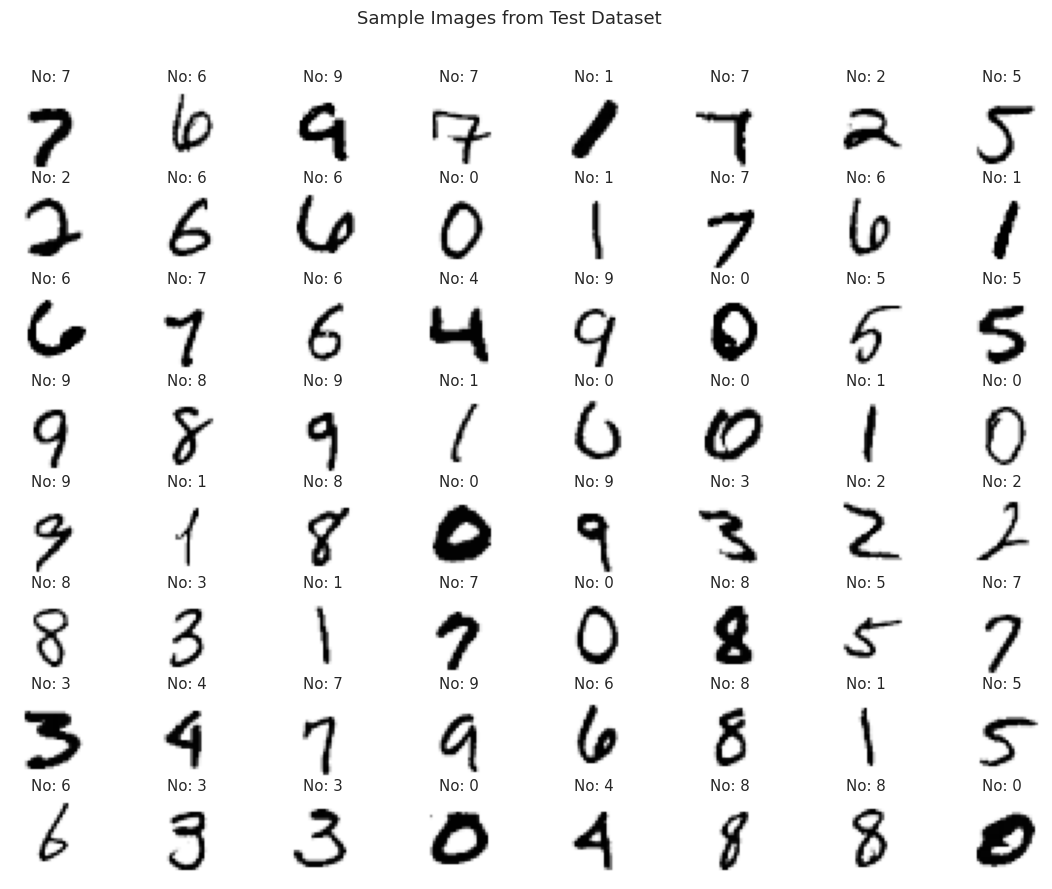

In [12]:
if SHOW_SAMPLE:
    print("Displaying random sample from test dataset")
    data_iter = iter(test_loader)
    # fetch first batch of 64 images & labels
    images, labels = next(data_iter)
    display_sample(
        images.cpu().numpy(),
        labels.cpu().numpy(),
        grid_shape=(8, 8),
        plot_title="Sample Images from Test Dataset",
    )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
           Dropout-7                   [-1, 64]               0
            Linear-8                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
----------------------------------------------------------------
None


Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch  1/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch  2/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch  3/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch  4/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch  5/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch  6/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch  7/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch  8/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch  9/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 10/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 11/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 12/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 13/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 14/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 15/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 16/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 17/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 18/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 19/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 20/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 21/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 22/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 23/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 24/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

Epoch 25/25:   0%|                              | 0/938 [00:00<?, ?it/s]

Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

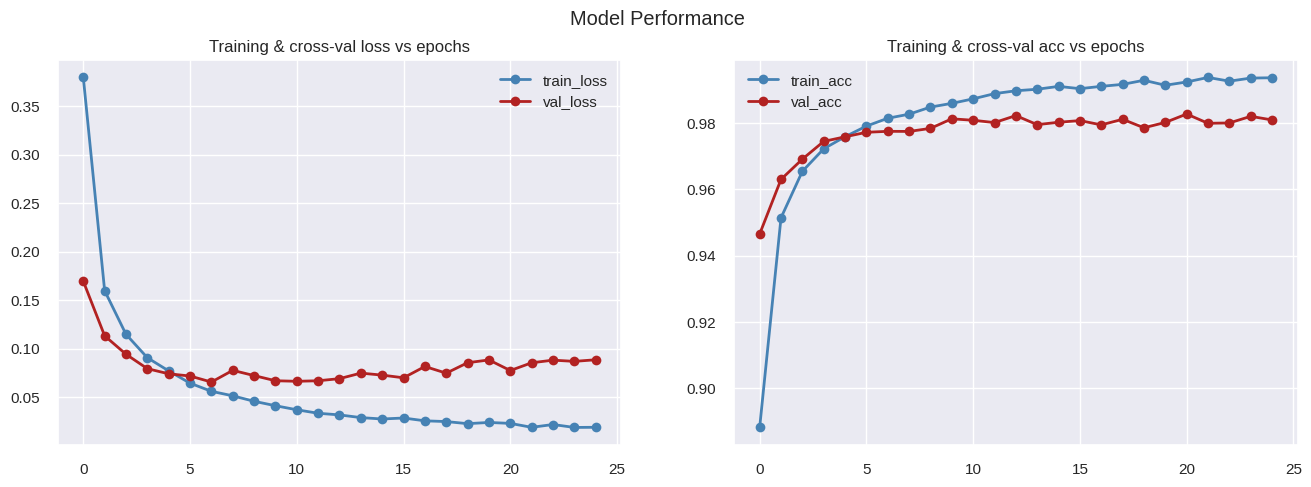

Pytorch model saved to /mnist/model_state/pyt_mnist_dnn.pth


In [14]:
if DO_TRAIN:
    model = MNISTModel(NUM_CLASSES, LR).to(DEVICE)
    print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

    metrics_history = pel.MetricsLogger()
    progbar = pel.EnLitProgressBar()
    trainer = pl.Trainer(
        max_epochs=EPOCHS,
        logger=metrics_history,
        callbacks=[progbar],
    )
    trainer.fit(
        model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
    )
    metrics_history.plot_metrics("Model Performance")
    pel.save_model(model, MODEL_STATE_PATH)
    del model
    del metrics_history
    del progbar

In [16]:
if DO_EVAL:
    model = MNISTModel(NUM_CLASSES, LR).to(DEVICE)
    # print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))
    model = pel.load_model(model, MODEL_STATE_PATH)
    print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

    # run a validation on Model
    progbar = pel.EnLitProgressBar()
    trainer = pl.Trainer(callbacks=[progbar])
    print(f"Validating on train-dataset...")
    trainer.validate(model, dataloaders=train_loader)
    print(f"Validating on val-dataset...")
    trainer.validate(model, dataloaders=val_loader)
    print(f"Validating on test-dataset...")
    trainer.validate(model, dataloaders=test_loader)
    del model
    del progbar

Pytorch model loaded from /mnist/model_state/pyt_mnist_dnn.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
           Dropout-7                   [-1, 64]               0
            Linear-8                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
--------------------------------------------

Validating:   0%|                                        | 0/938 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9984220862388611     │
│      val_loss_epoch       │   0.004919891711324453    │
└───────────────────────────┴───────────────────────────┘

Validating on val-dataset...


Validating:   0%|                                        | 0/125 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9809485077857971     │
│      val_loss_epoch       │    0.08850978314876556    │
└───────────────────────────┴───────────────────────────┘

Validating on test-dataset...


Validating:   0%|                                        | 0/32 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9852332472801208     │
│      val_loss_epoch       │    0.07464353740215302    │
└───────────────────────────┴───────────────────────────┘

Pytorch model loaded from /mnist/model_state/pyt_mnist_dnn.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
           Dropout-7                   [-1, 64]               0
            Linear-8                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
--------------------------------------------

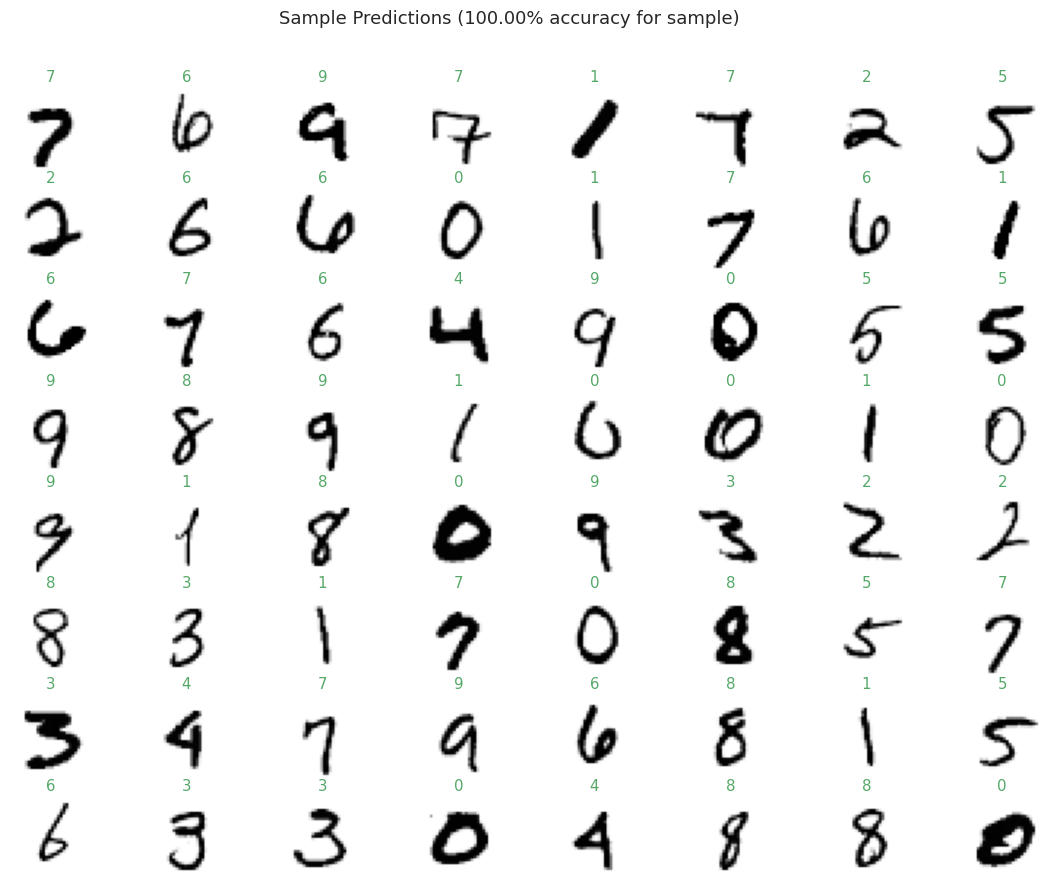

In [17]:
if DO_PRED:
    model = MNISTModel(NUM_CLASSES, LR).to(DEVICE)
    # print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))
    model = pel.load_model(model, MODEL_STATE_PATH)
    print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

    # predict from test_dataset
    preds, actuals = pel.predict_module(model, test_loader, DEVICE)
    preds = np.argmax(preds, axis=1)
    print("Sample labels (50): ", actuals[:50])
    print("Sample predictions: ", preds[:50])
    print("We got %d/%d incorrect!" % ((preds != actuals).sum(), len(actuals)))

    if SHOW_SAMPLE:
        # display sample predictions
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        preds, actuals = pel.predict_module(
            model,
            (images.cpu().numpy(), labels.cpu().numpy()),
            DEVICE,
        )
        preds = np.argmax(preds, axis=1)
        accu = (preds == actuals).sum() / len(actuals)
        display_sample(
            images,
            actuals[:BATCH_SIZE],
            sample_predictions=preds[:BATCH_SIZE],
            grid_shape=(8, 8),
            plot_title=f"Sample Predictions ({accu*100:.2f}% accuracy for sample)",
        )
    del model